In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

from flowjax.bijections import (
    Affine,
    Concatenate,
    Invert,
    RationalQuadraticSpline,
    Scan,
    Stack,
    Tanh,
)
from flowjax.bijections.utils import Identity
from flowjax.distributions import Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow, _add_default_permute
from flowjax.train import fit_to_data
from flowjax.utils import get_ravelled_pytree_constructor
from flowjax.wrappers import NonTrainable
from jaxtyping import ArrayLike

from frugal_flows.basic_flows import (
    masked_autoregressive_flow_first_uniform,
    masked_independent_flow,
    masked_autoregressive_flow_transformer_cond,
    masked_autoregressive_flow_masked_cond,
)
from frugal_flows.bijections import UnivariateNormalCDF, RationalQuadraticSplineCond, LocCond, MaskedAutoregressiveMaskedCond
SEED = 8
jax.config.update("jax_enable_x64", True)

In [2]:
Invert

flowjax.bijections.utils.Invert

In [2]:
keys = jr.split(jr.PRNGKey(SEED+6), 3)

N = 10000

# z = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(N,))


x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
# x = jnp.expand_dims(jnp.ones(int(N))*0, axis=1)
# x = jax.random.normal(keys[0], shape=(N,1))

y = jnp.vstack([jax.random.normal(keys[2], shape=(int(N/2),1)), 
                                jax.random.normal(keys[0], shape=(int(N/2),1))*5.])

# y = jax.random.normal(keys[2], shape=(N,1)) + 1*x 

In [3]:
y.min(), y.max()

(Array(-21.2385722, dtype=float64), Array(18.65226771, dtype=float64))

In [4]:
y.shape

(10000, 1)

In [35]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(9))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

flow = masked_autoregressive_flow_masked_cond(  # masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    # cond_dim=x.shape[1],
    cond_dim_mask=x.shape[1],
    nn_depth=5,
    nn_width=50,
    flow_layers=10,
)  # Support on [-1, 1]

flow = Transformed(flow, Invert(Tanh(flow.shape)))  # Unbounded support

flow = Transformed(
    flow,
    LocCond(ate=jnp.ones(nvars)*0.)
)

flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
)

key, subkey = jr.split(key)

# Train
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=y,
    learning_rate=1e-2,
    max_patience=30,
    max_epochs=400,
    batch_size=1000,
    show_progress=True,
    val_prop=0.1,
    condition=x,
)

 93%|████████████████████████████████████████████████████████████████▏    | 372/400 [04:15<00:19,  1.46it/s, train=2.5433482167032966, val=2.5946330017086843 (Max patience reached)]


In [36]:
flow_masked = flow

In [34]:
flow_unmasked = flow

In [23]:
flow.bijection.bijections[3].ate

Array([-0.29786788], dtype=float64)

In [24]:
flow.bijection.bijections[3].ate

Array([-0.29786788], dtype=float64)

In [25]:
keys = jr.split(jr.PRNGKey(SEED+8), 8)

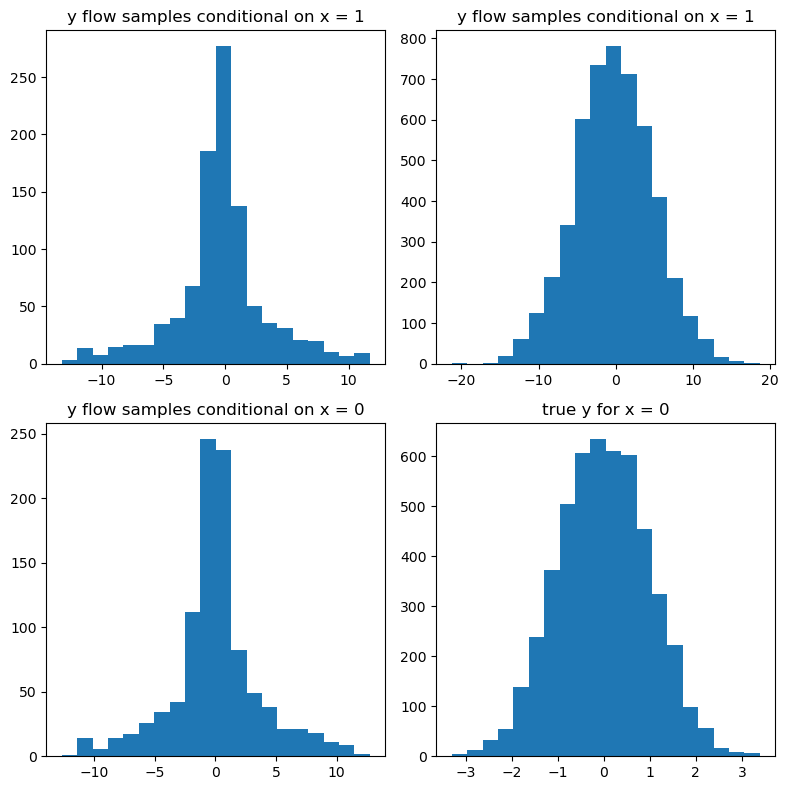

In [37]:
n_samples = 1000
fig,ax =plt.subplots(2,2, figsize=(8,8))
flow_samples_1 = flow_masked.sample(keys[1], condition=jnp.ones((n_samples,1)))
ax[0,0].set_title('y flow samples conditional on x = 1')
ax[0,0].hist(flow_samples_1[:,0], label="flow", bins=20)

ax[0,1].set_title('y flow samples conditional on x = 1')
ax[0,1].hist(y[x==1], label="flow", bins=20)

flow_samples_0 = flow_masked.sample(keys[0], condition=jnp.zeros((n_samples,1)))
ax[1,0].set_title('y flow samples conditional on x = 0')
ax[1,0].hist(flow_samples_0[:,0], label="flow", bins=20)

ax[1,1].set_title('true y for x = 0')
ax[1,1].hist(y[x==0], label="y", bins=20)
plt.tight_layout()
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

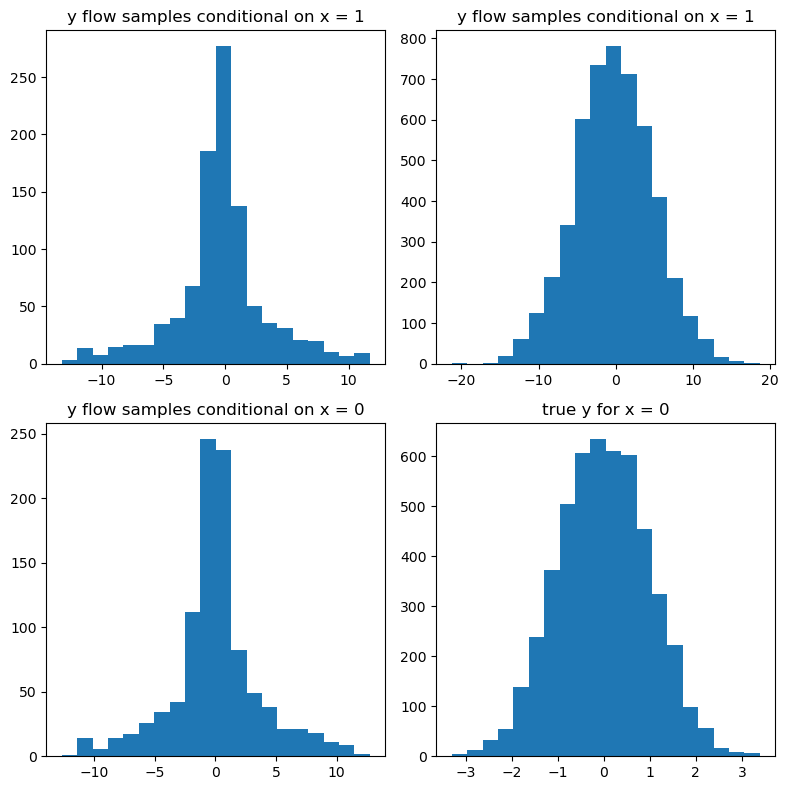

In [26]:
n_samples = 1000
fig,ax =plt.subplots(2,2, figsize=(8,8))
flow_samples_1 = flow.sample(keys[1], condition=jnp.ones((n_samples,1)))
ax[0,0].set_title('y flow samples conditional on x = 1')
ax[0,0].hist(flow_samples_1[:,0], label="flow", bins=20)

ax[0,1].set_title('y flow samples conditional on x = 1')
ax[0,1].hist(y[x==1], label="flow", bins=20)

flow_samples_0 = flow.sample(keys[0], condition=jnp.zeros((n_samples,1)))
ax[1,0].set_title('y flow samples conditional on x = 0')
ax[1,0].hist(flow_samples_0[:,0], label="flow", bins=20)

ax[1,1].set_title('true y for x = 0')
ax[1,1].hist(y[x==0], label="y", bins=20)
plt.tight_layout()
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [28]:
flow_samples_0.std(), flow_samples_1.std()

(Array(3.67965261, dtype=float64), Array(3.73378208, dtype=float64))

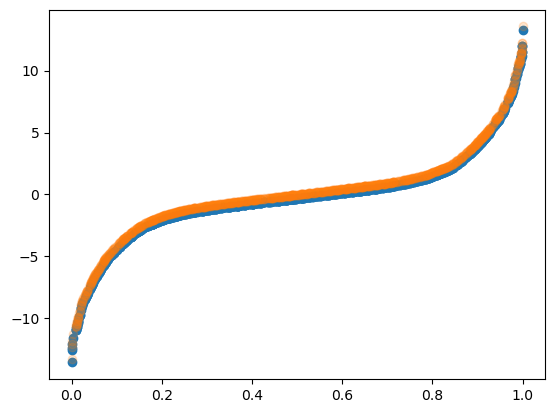

In [38]:
uni_standard = jr.uniform(keys[2], shape=(n_samples, 1))
uni_minus1_plus1 = jax.vmap(flow_masked.bijection.bijections[0].tree.transform)(uni_standard)

y_minus1_plus1_x1 = jax.vmap(flow_masked.bijection.bijections[1].transform)(uni_minus1_plus1, jnp.ones((n_samples,1)))
y_minus1_plus1_x0 = jax.vmap(flow_masked.bijection.bijections[1].transform)(uni_minus1_plus1, jnp.zeros((n_samples,1)))

y_tanh_x1 = jax.vmap(flow_masked.bijection.bijections[2].transform)(y_minus1_plus1_x1, jnp.ones((n_samples,1)))
y_tanh_x0 = jax.vmap(flow_masked.bijection.bijections[2].transform)(y_minus1_plus1_x0, jnp.zeros((n_samples,1)))

y_flow_x1 = jax.vmap(flow_masked.bijection.bijections[3].transform)(y_tanh_x1, jnp.ones((n_samples,1)))
y_flow_x0 = jax.vmap(flow_masked.bijection.bijections[3].transform)(y_tanh_x0, jnp.zeros((n_samples,1)))

plt.scatter(uni_standard.flatten(), y_flow_x1.flatten())
plt.scatter(uni_standard.flatten(), y_flow_x0.flatten(), alpha=0.2)

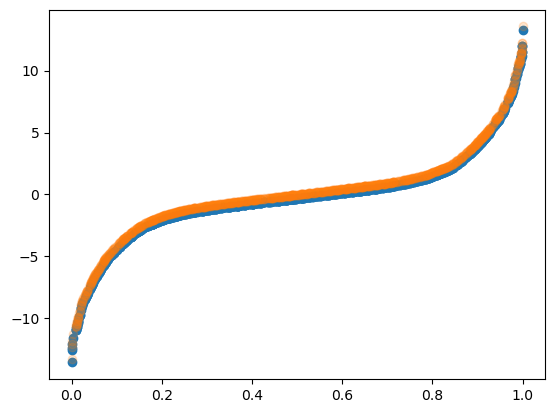

In [39]:
uni_standard = jr.uniform(keys[2], shape=(n_samples, 1))
uni_minus1_plus1 = jax.vmap(flow_unmasked.bijection.bijections[0].tree.transform)(uni_standard)

y_minus1_plus1_x1 = jax.vmap(flow_unmasked.bijection.bijections[1].transform)(uni_minus1_plus1, jnp.ones((n_samples,1)))
y_minus1_plus1_x0 = jax.vmap(flow_unmasked.bijection.bijections[1].transform)(uni_minus1_plus1, jnp.zeros((n_samples,1)))

y_tanh_x1 = jax.vmap(flow_unmasked.bijection.bijections[2].transform)(y_minus1_plus1_x1, jnp.ones((n_samples,1)))
y_tanh_x0 = jax.vmap(flow_unmasked.bijection.bijections[2].transform)(y_minus1_plus1_x0, jnp.zeros((n_samples,1)))

y_flow_x1 = jax.vmap(flow_unmasked.bijection.bijections[3].transform)(y_tanh_x1, jnp.ones((n_samples,1)))
y_flow_x0 = jax.vmap(flow_unmasked.bijection.bijections[3].transform)(y_tanh_x0, jnp.zeros((n_samples,1)))

plt.scatter(uni_standard.flatten(), y_flow_x1.flatten())
plt.scatter(uni_standard.flatten(), y_flow_x0.flatten(), alpha=0.2)

In [22]:
mykeys = jr.split(jr.PRNGKey(SEED+6), 3)

N = 10000

z = jr.multivariate_normal(mykeys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(N,))


x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
y = jax.random.normal(mykeys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

u_z = jax.scipy.stats.norm.cdf(z, loc=0, scale=1)

In [25]:
flow_layers = 5
dim=1
invert = True
transformer_ate = RationalQuadraticSpline(knots=8, interval=1)
def make_layer(key):  # masked autoregressive layer + permutation
    bij_key, perm_key = jr.split(mykeys[0])
    bijection = MaskedAutoregressiveMaskedCond(
        key=bij_key,
        transformer=transformer_ate,
        dim=dim,
        cond_dim_mask=x.shape[1],
        nn_width=50,
        nn_depth=4,
    )
    return _add_default_permute(bijection, dim, perm_key)

keys = jr.split(mykeys[0], flow_layers)
layers = eqx.filter_vmap(make_layer)(keys)
ate_maf_bijection = Invert(Scan(layers)) if invert else Scan(layers)

In [26]:

nvars = u_z.shape[1]
ate_init = 5.
key, subkey = jr.split(mykeys[1])


cond_dim = x.shape[1]


list_bijections_ate_maf = [ate_maf_bijection] + [Identity((1,))] * nvars
bijections_ate_maf = Concatenate(list_bijections_ate_maf)

list_bijections_tanh = [Invert(Tanh(()))] + [Identity(())] * nvars
bijections_tanh = Stack(list_bijections_tanh)

list_bijections_loccond = [LocCond(ate=ate_init)] + [Identity(())] * nvars
bijections_loccond = Stack(list_bijections_loccond)

list_bijections_affine = [Identity((1,))] + [Invert(Affine(loc=-jnp.ones(nvars), scale=jnp.ones(nvars) * 2))]
bijections_affine = Concatenate(list_bijections_affine)

base_dist = Uniform(-jnp.ones(nvars + 1), jnp.ones(nvars + 1))

transformer = RationalQuadraticSpline(knots=8, interval=1)
frugal_flow = (
    masked_autoregressive_flow_first_uniform(  # masked_autoregressive_flow(
        key=subkey,
        base_dist=base_dist,
        transformer=transformer,
        invert=True,
        cond_dim_mask=cond_dim,
        nn_depth=5,
        nn_width=50,
        stop_grad_until=None,
        # cond_dim_nomask=x.shape[1],
        # cond_dim=x.shape[1],
    )
)  # Support on [-1, 1]

# frugal_flow = Transformed(
#     frugal_flow,
#     Invert(Affine(loc=-jnp.ones(nvars + 1), scale=jnp.ones(nvars + 1) * 2)),
# )

frugal_flow = Transformed(
    frugal_flow,
    bijections_affine,
)


frugal_flow = Transformed(
    frugal_flow,
    bijections_ate_maf,
)

frugal_flow = Transformed(
    frugal_flow,
    bijections_tanh,
)

frugal_flow = Transformed(
    frugal_flow,
    bijections_loccond,
)

frugal_flow = frugal_flow.merge_transforms()

assert isinstance(frugal_flow.base_dist, _StandardUniform)

frugal_flow = eqx.tree_at(
    where=lambda frugal_flow: frugal_flow.bijection.bijections[0],
    pytree=frugal_flow,
    replace_fn=NonTrainable,
)

frugal_flow = eqx.tree_at(
    where=lambda frugal_flow: frugal_flow.bijection.bijections[-4],
    pytree=frugal_flow,
    replace_fn=NonTrainable,
)

key, subkey = jr.split(key)

# Train
frugal_flow, losses = fit_to_data(
    key=subkey,
    dist=frugal_flow,
    x=jnp.hstack([y, u_z]),
    condition=x,
    learning_rate=1e-3,
    max_epochs=300,
    max_patience=100,
    batch_size=100,
    val_prop=0.1,
)


 63%|███████████████         | 188/300 [04:11<02:29,  1.34s/it, train=1.3624445, val=1.4468359 (Max patience reached)]


In [27]:
frugal_flow_samples = frugal_flow.sample(key, condition=jnp.ones((10000,1))) #
frugal_flow_samples.shape

(10000, 3)

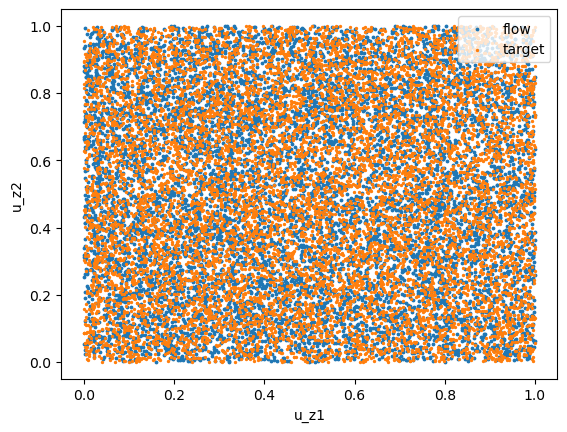

In [28]:
plt.scatter(*frugal_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [30]:
frugal_flow.bijection.bijections[-1].bijections[0].ate

Array(1.1394907, dtype=float32)

In [31]:
n_samples = 1000
flow_samples_1 = flow.sample(keys[0], condition=jnp.ones((n_samples,1)))
flow_samples_0 = flow.sample(keys[1], condition=jnp.zeros((n_samples,1)))

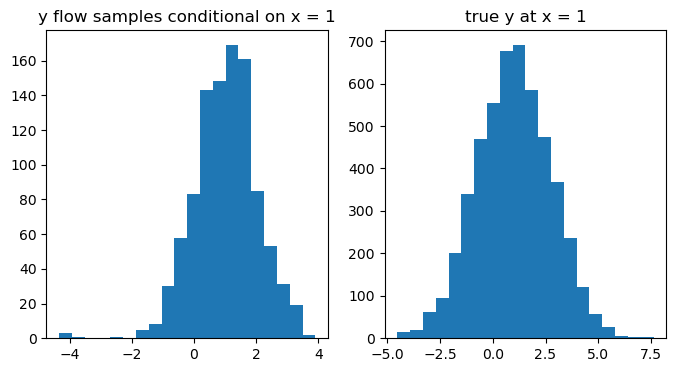

In [32]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 1')
ax[0].hist(flow_samples_1[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 1')
ax[1].hist(y[x==1], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

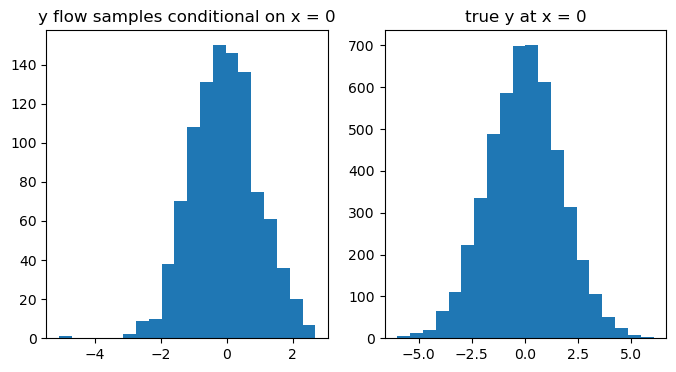

In [33]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 0')
ax[0].hist(flow_samples_0[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 0')
ax[1].hist(y[x==0], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()